# tensors

In [ ]:
#| default_exp tensors

In [ ]:
#| hide
#| export
from nbdev.showdoc import *
from typing import Optional

from PIL import Image
import torch

from fastcore.test import test_eq
from fastcore.foundation import patch_to

# import wandb

In [ ]:
# |exporti
class __PrinterOptions(object):
    precision: int = 3
    threshold_max: int = 3 # .abs() larger than 1e3 -> Sci mode
    threshold_min: int = -4 # .abs() smaller that 1e-4 -> Sci mode
    sci_mode: Optional[bool] = None # None = auto. Otherwise, force sci mode.
    indent: int = 2 # Indent for .deeper()
    color: bool = False


In [ ]:
# |export
PRINT_OPTS = __PrinterOptions()

In [ ]:
# |hide
# |exporti
# Do we want this float in decimal or scientific mode?
def sci_mode(f: float):
    return (abs(f) < 10**(PRINT_OPTS.threshold_min) or
            abs(f) > 10**PRINT_OPTS.threshold_max)

In [ ]:
# |hide
test_eq(sci_mode(1.), False)
test_eq(sci_mode(0.00001), True)
test_eq(sci_mode(10000000), True)

# It would be fine either way, both `e` and `f` formats handle those.
test_eq(sci_mode(float('nan')), False)
test_eq(sci_mode(float('inf')), True) 

In [ ]:
# |hide

# What's happening in the cell below
fmt = f"{{:.{4}{'e'}}}"
fmt, fmt.format(1.23)

('{:.4e}', '1.2300e+00')

In [ ]:
# |export

# Convert a tensor into a string.
# This only looks good for small tensors, which is how it's intended to be used.
def tensor_str(t: torch.Tensor):
    """A slightly better way to print `float` values"""
    if t.dim() == 0:
        v = t.item()
        if t.is_floating_point():
            if not t.is_nonzero():
                return "0."

            sci = (PRINT_OPTS.sci_mode or
                    (PRINT_OPTS.sci_mode is None and sci_mode(v)))

            # The f-string will generate something like "{.4f}", which is used
            # to format the value.
            return f"{{:.{PRINT_OPTS.precision}{'e' if sci else 'f'}}}".format(v)
        else:
            return '{}'.format(v) # Should we use sci mode for large ints too?
    else:
        slices = [tensor_str(t[i]) for i in range(0, t.size(0))]
        return '[' + ", ".join(slices) + ']'

In [ ]:
# |hide
torch.manual_seed(42)
randoms = torch.randn(100)

In [ ]:
nasties = randoms[:12].clone()

nasties[0] *= 10000
nasties[1] /= 10000
nasties[3] = float('inf')
nasties[4] = float('-inf')
nasties[5] = float('nan')
nasties = nasties.reshape((2,6))


In [ ]:
tensor_str(nasties)

'[[1.927e+04, 0.000, 0.901, inf, -inf, nan], [-0.043, -1.605, -0.752, 1.649, -0.392, -1.404]]'

In [ ]:
# |hide
test_eq(tensor_str(nasties), '[[1.927e+04, 0.000, 0.901, inf, -inf, nan], [-0.043, -1.605, -0.752, 1.649, -0.392, -1.404]]')

In [ ]:
# |exporti
# |hide
def space_join(lst):
    # Join non-empty list elements into a space-sepaeated string
    return " ".join( [ l for l in lst if l] )

In [ ]:
# |hide
test_eq(space_join(["Hello", None, "World"]), 'Hello World')

In [ ]:
#| exporti

class LovelyProxy():
    def __init__(self, t: torch.Tensor, plain=False, verbose=False, depth=0, lvl=0):
        self.t = t
        self.plain = plain
        self.verbose = verbose
        self.depth=depth
        self.lvl=lvl

    @torch.no_grad()
    def to_str(self):
        t = self.t
        if self.plain:
            return torch._tensor_str._tensor_str(t, indent=0)

        
        grey_style = "\x1b[38;2;127;127;127m" if PRINT_OPTS.color else ""
        red_style = "\x1b[31m" if PRINT_OPTS.color else ""
        end_style = "\x1b[0m" if PRINT_OPTS.color else ""

        tname = "tensor" if type(t) in [torch.Tensor, torch.nn.Parameter] else type(t).__name__

        grad_fn = "grad_fn" if t.grad_fn else None
        # All tensors along the compute path actually have required_grad=True. Torch __repr__ just dones not show it.
        grad = "grad" if not t.grad_fn and t.requires_grad else None

        shape = str(list(t.shape))

        zeros = grey_style+"all_zeros"+end_style if not t.count_nonzero() else None
        pinf = red_style+"+inf!"+end_style if t.isposinf().any() else None
        ninf = red_style+"-inf!"+end_style if t.isneginf().any() else None
        nan = red_style+"nan!"+end_style if t.isnan().any() else None

        # zeros = "all_zeros" if not t.count_nonzero() else None
        # pinf = "+inf!" if t.isposinf().any() else None
        # ninf = "-inf!" if t.isneginf().any() else None
        # nan = "nan!" if t.isnan().any() else None

        attention = space_join([zeros,pinf,ninf,nan])

        x = summary = ""
        if not zeros:
            if t.numel() <= 10: x = " x=" + tensor_str(t)

            # Make sure it's float32. Also, we calculate stats on good values only.
            ft = t.float()[  torch.isfinite(t) ]

            minmax = f"x∈[{tensor_str(ft.min())}, {tensor_str(ft.max())}]" if t.numel() > 2 and ft.numel() > 2 else None
            meanstd = f"μ={tensor_str(ft.mean())} σ={tensor_str(ft.std())}" if t.numel() >= 2 and ft.numel() >= 2 else None
            numel = f"n={t.numel()}" if t.numel() > 5 else None

            summary = space_join([numel, minmax, meanstd])

        dtnames = { torch.float32: "",
                    torch.float16: "f16",
                    torch.float64: "f64",
                    torch.uint8: "u8",
                    torch.int32: "i32",
                }

        dtype = dtnames[t.dtype] if t.dtype in dtnames else str(t.dtype)[6:]
        dev = str(t.device) if t.device.type != "cpu" else None

        res = tname + space_join([shape,summary,dtype,grad,grad_fn,dev,attention])

        res += ("\nx=" + torch._tensor_str._tensor_str(t, indent=PRINT_OPTS.indent) if self.verbose else x)

        if self.depth and t.dim() > 1:
            res += "\n"
            # for i in range(t.shape[0]):
                # str = 
            res += "\n".join([
                " "*PRINT_OPTS.indent*(self.lvl+1) +
                str(LovelyProxy(t[i,:], depth=self.depth-1, lvl=self.lvl+1))
                for i in range(t.shape[0])])

        return res
    
    def __repr__(self):
        return self.to_str()

    def __call__(self, depth=0):
        return LovelyProxy(self.t, depth=depth)



Would be _lovely_ if you could see all the important tensor stats too?

In [ ]:
# |export
def lovely(t: torch.Tensor, verbose=False, plain=False, depth=0):
    return LovelyProxy(t, verbose=verbose, plain=plain, depth=depth)

In [ ]:
print(lovely(randoms[0]))
print(lovely(randoms[:2]))
print(lovely(randoms[:6].view(2, 3))) # More than 2 elements -> show statistics
print(lovely(randoms[:11])) # More than 10 -> suppress data output


tensor[] x=1.927
tensor[2] μ=1.707 σ=0.311 x=[1.927, 1.487]
tensor[2, 3] n=6 x∈[-2.106, 1.927] μ=0.276 σ=1.594 x=[[1.927, 1.487, 0.901], [-2.106, 0.678, -1.235]]
tensor[11] n=11 x∈[-2.106, 1.927] μ=0.046 σ=1.384


In [ ]:
# |hide
test_eq(str(lovely(randoms[0])), "tensor[] x=1.927")
test_eq(str(lovely(randoms[:2])), "tensor[2] μ=1.707 σ=0.311 x=[1.927, 1.487]")
test_eq(str(lovely(randoms[:6].view(2, 3))), "tensor[2, 3] n=6 x∈[-2.106, 1.927] μ=0.276 σ=1.594 x=[[1.927, 1.487, 0.901], [-2.106, 0.678, -1.235]]")
test_eq(str(lovely(randoms[:11])), "tensor[11] n=11 x∈[-2.106, 1.927] μ=0.046 σ=1.384")

In [ ]:
grad = torch.tensor(1., requires_grad=True)
print(lovely(grad)); print(lovely(grad+1))

tensor[] grad x=1.000
tensor[] grad_fn x=2.000


In [ ]:
# |hide
test_eq(str(lovely(grad)), "tensor[] grad x=1.000")
test_eq(str(lovely(grad+1)), "tensor[] grad_fn x=2.000")

In [ ]:
if torch.cuda.is_available():
    print(lovely(torch.tensor(1., device=torch.device("cuda:0"))))
    test_eq(str(lovely(torch.tensor(1., device=torch.device("cuda:0")))), "tensor[] cuda:0 x=1.000")

tensor[] cuda:0 x=1.000


Do we have __any__ floating point nasties? Is the tensor __all__ zeros?

In [ ]:
PRINT_OPTS.color=True

# Statistics and range are calculated on good values only, if there are at lest 3 of them.
str(lovely(nasties))


'tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 \x1b+inf!\x1b \x1b-inf!\x1b \x1bnan!\x1b'

In [ ]:
lovely(torch.tensor([float("nan")]*11))


tensor[11] n=11 nan!

In [ ]:
str(lovely(torch.zeros(12)))

'tensor[12] \x1ball_zeros\x1b'

In [ ]:
test_eq(str(lovely(nasties)),
    'tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 \x1b[31m+inf!\x1b[0m \x1b[31m-inf!\x1b[0m \x1b[31mnan!\x1b[0m')
test_eq(str(lovely(torch.tensor([float("nan")]*11))), 'tensor[11] n=11 \x1b[31mnan!\x1b[0m')
test_eq(str(lovely(torch.zeros(12))), 'tensor[12] \x1b[38;2;127;127;127mall_zeros\x1b[0m')

In [ ]:
in_stats = { "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225) }
image = torch.load("mysteryman.pt")

In [ ]:
torch.set_printoptions(linewidth=120)

print("Verbose:")
print(lovely(nasties, verbose=True))
print("\nPlain:")
print(lovely(nasties, plain=True))

Verbose:
tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!
x=[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
   [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

Plain:
[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
 [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]


In [ ]:
image[1,100,100] = float('nan')
lovely(image, depth=1)

tensor[3, 196, 196] n=115248 x∈[-2.118, 2.640] μ=-0.388 σ=1.073 nan!
  tensor[196, 196] n=38416 x∈[-2.118, 2.249] μ=-0.324 σ=1.036
  tensor[196, 196] n=38416 x∈[-1.966, 2.429] μ=-0.274 σ=0.973 nan!
  tensor[196, 196] n=38416 x∈[-1.804, 2.640] μ=-0.567 σ=1.178

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.
class ProxyImage(Image.Image): 
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor):
        super().__init__()
        self.t = t.permute(1, 2, 0)

        # Mode and size - to be used by super().__repr__()
        self.mode = "RGB"
        self._size = tuple(t.shape[1:])

    @torch.no_grad()
    def __call__(self, denorm=None):            
        means = torch.tensor(denorm["mean"] if denorm else (0., 0., 0.,))
        stds = torch.tensor(denorm["std"] if denorm else (1., 1., 1.,))
        return Image.fromarray((self.t*stds+means).mul(255).byte().numpy())

    @torch.no_grad()
    def _repr_png_(self):
        "Jupyter PNG representation"
        return Image.fromarray(self.t.mul(255).byte().numpy())._repr_png_()


In [ ]:
# |export
def rgb(t: torch.Tensor, denorm=None):
    return ProxyImage(t)(denorm)

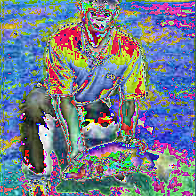

In [ ]:
rgb(image)

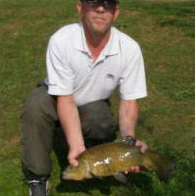

In [ ]:
rgb(image, denorm=in_stats)

In [ ]:
# |export
def monkey_patch(cls=torch.Tensor):
    "Monkey-patch lovely features into `cls`" 

    @patch_to(cls)
    def __repr__(self: torch.Tensor, *, tensor_contents=None):        
        return str(LovelyProxy(self))

    # Keep an esiy way to get the standard behavior.
    @patch_to(cls, as_prop=True)
    def plain(self: torch.Tensor, *, tensor_contents=None):
        return LovelyProxy(self, plain=True)

    # And a verbose option for a good measure.
    @patch_to(cls, as_prop=True)
    def verbose(self: torch.Tensor, *, tensor_contents=None):
        return LovelyProxy(self, verbose=True)

    @patch_to(cls, as_prop=True)
    def deeper(self: torch.Tensor):
        return LovelyProxy(self, depth=1)

    @patch_to(cls, as_prop=True)
    def rgb(t: torch.Tensor):
        return ProxyImage(t)

In [ ]:
monkey_patch()

In [ ]:
nasties

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!

In [ ]:
nasties.verbose

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!
x=[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
   [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
nasties.plain

[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
 [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
# Per-channel statistics of an image
image.deeper

tensor[3, 196, 196] n=115248 x∈[-2.118, 2.640] μ=-0.388 σ=1.073 nan!
  tensor[196, 196] n=38416 x∈[-2.118, 2.249] μ=-0.324 σ=1.036
  tensor[196, 196] n=38416 x∈[-1.966, 2.429] μ=-0.274 σ=0.973 nan!
  tensor[196, 196] n=38416 x∈[-1.804, 2.640] μ=-0.567 σ=1.178

In [ ]:
# Not sure it we are back to the "too many numbers" territory here, but
# if you want to go deeper, you can.

dt = torch.randn(3, 3, 5)
dt.deeper(3)

tensor[3, 3, 5] n=45 x∈[-1.547, 2.027] μ=0.283 σ=0.748
  tensor[3, 5] n=15 x∈[-0.705, 1.095] μ=0.266 σ=0.622
    tensor[5] x∈[-0.389, 1.031] μ=0.397 σ=0.557 x=[0.726, 0.091, -0.389, 0.528, 1.031]
    tensor[5] x∈[-0.705, 1.095] μ=0.282 σ=0.798 x=[-0.705, 1.013, -0.331, 1.095, 0.340]
    tensor[5] x∈[-0.573, 0.720] μ=0.118 σ=0.598 x=[0.720, 0.411, -0.573, 0.507, -0.475]
  tensor[3, 5] n=15 x∈[-0.687, 1.635] μ=0.251 σ=0.641
    tensor[5] x∈[-0.492, 1.635] μ=0.448 σ=0.821 x=[-0.492, -0.136, 1.635, 0.655, 0.576]
    tensor[5] x∈[-0.375, 0.819] μ=0.019 σ=0.487 x=[-0.361, -0.061, 0.073, 0.819, -0.375]
    tensor[5] x∈[-0.687, 1.033] μ=0.286 σ=0.639 x=[1.033, -0.687, 0.637, 0.218, 0.229]
  tensor[3, 5] n=15 x∈[-1.547, 2.027] μ=0.331 σ=0.978
    tensor[5] x∈[-0.731, 0.287] μ=-0.118 σ=0.418 x=[0.025, -0.346, 0.287, -0.731, 0.175]
    tensor[5] x∈[-1.094, 1.353] μ=0.513 σ=1.037 x=[-1.094, 0.963, 1.353, 1.289, 0.052]
    tensor[5] x∈[-1.547, 2.027] μ=0.599 σ=1.308 x=[-1.547, 0.757, 0.776, 2.027, 

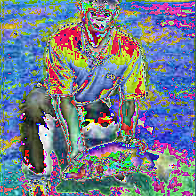

In [ ]:
image.rgb

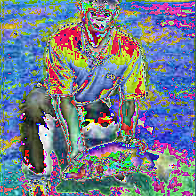

In [ ]:
image.rgb()

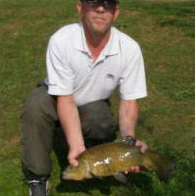

In [ ]:
image.rgb(in_stats)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()